<table><tr>
<td> <img src="resources/20210519_header_jupyter_notebooks.png" alt="Drawing", style="float:left;margin:0 10px 10px 0" markdown="1"/> </td>
</tr></table>


\textbf{Author}: Manuel A. Morgado V. 

\textbf{Affiliation}: 

- \textit{Institut de Science et d’Ingénierie Supramoléculaires (ISIS, UMR7006), University of Strasbourg and CNRS}

- \textit{Centre Européen de Sciences Quantiques (CESQ-ISIS, UMR7006), University of Strasbourg and CNRS}

\textbf{Created}: Dec.01, 2021

\textbf{Last Modification}: Dec.08, 2021

\textbf{License}: http://www.apache.org/licenses/LICENSE-2.0

# Preamble

In [1]:
#libs

import numpy as np
import csv
import scipy as scp
from scipy.optimize import curve_fit
from scipy.integrate import quad

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from IPython.display import clear_output
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:85% !important; }</style>"))

import AQiPTbeta as aqipt

In [2]:
def oscReadout(fname, nr_files, startLine=3, endLine=None, format='.csv'):
    traces = [];
    for _ in range(0,nr_files):

        with open(fname+str(_)+format, newline='') as f:
            reader = csv.reader(f)
            data = list(reader)

        valsX = []
        valsY = []
        endLine= len(data)
        print(endLine)
        for i in range(startLine,endLine):
            valsX.append(float(data[i][0]))
            valsY.append(float(data[i][1]))

        traces.append([valsX, valsY])
        
    return traces

# Get data

In [3]:
#read csv
fname = 'oscilloscope_acq/20211202/scope_'
nr_files = 9
traces = oscReadout(fname, nr_files)


7677
7677
4800
7678
5002
5002
5002
5002
1002


# Ploting data

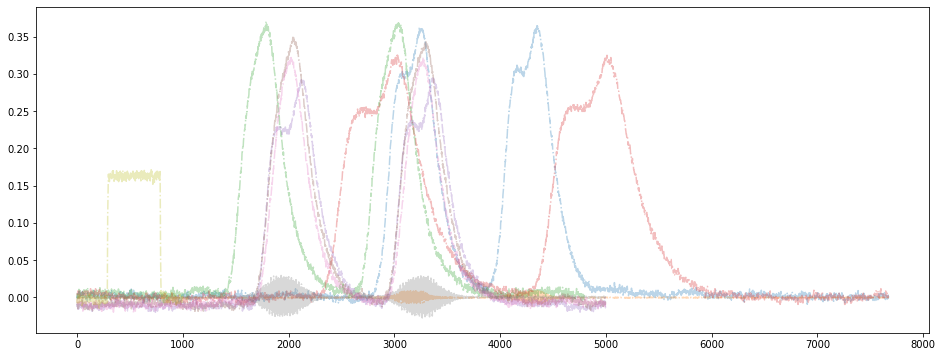

In [4]:
plt.figure(figsize=(16,6))
i=0;
for trace in traces:
    plt.plot( (traces[i])[1], '-.', alpha=0.3, label='Trace '+str(i));
    i+=1;

# PDA response and pulse waveform

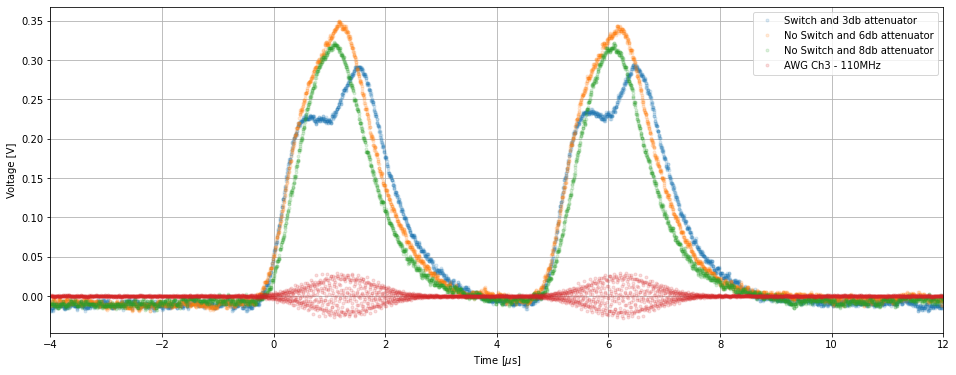

In [567]:
plt.figure(figsize=(16,6))

i=4
plt.plot([((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))], (traces[i])[1], '.', alpha=0.15, label='Switch and 3db attenuator');

i=5
plt.plot([((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))], (traces[i])[1], '.', alpha=0.15, label='No Switch and 6db attenuator');

i=6
plt.plot([((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))], (traces[i])[1], '.', alpha=0.15, label='No Switch and 8db attenuator');

i=7
plt.plot([((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))], (traces[i])[1], '.', alpha=0.15, label='AWG Ch3 - 110MHz');

plt.xlabel(r'Time [$\mu$s]');
plt.ylabel(r'Voltage [V]');
plt.xlim(-4,12);
plt.grid(True);
plt.legend();

In [6]:
from scipy.optimize import curve_fit

def func(x, a, b, c, xo): #exponential decay
    return a * np.exp(-b * (x-np.array([xo]*len(x)))) + c
def func2(x, a, b, c, xo): #exponential growth
    return a * np.exp(b * (x-np.array([xo]*len(x)))) + c
def func3(x, a, mu, sig, c): #gaussian
    return a*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + c


# Waveform from oscilloscope

array([3.00000000e-002, 1.17021746e+000, 6.50000000e-001, 2.56946619e-114])

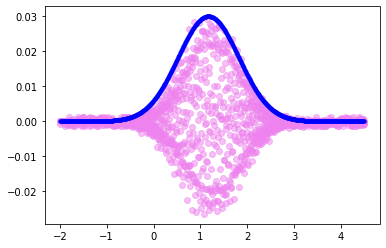

In [7]:
#square pulse measure in the PD with 5KHz TTL signal @110MHz

i=7;
x = [((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y = (traces[i])[1]

#modulated Gaussian
new_idx=(np.array(x) > -2.) & (np.array(x) < 4.5);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

# plt.plot(x,y)
popt, pcov = curve_fit(func3, xnew, ynew, bounds=([0.03, 1.15, 0.65, 0], [ 0.05, 1.2, 0.7, 0.01]) )

plt.scatter(xnew, ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]
plt.plot(xnew, func3(np.array(xnew), popt[0],popt[1],popt[2],popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

# Electronic switch - response/relaxation time

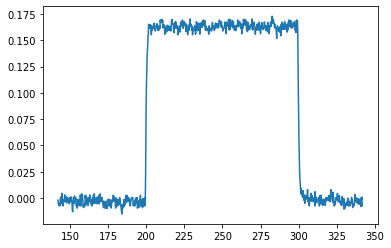

In [8]:
#square pulse measure in the PD with 10KHz TTL signal @110MHz

i=8;
x = [((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y = (traces[i])[1]

plt.plot(x,y)

array([7.53788786e-14, 7.07357853e-01, 2.92769335e-27, 1.61293923e+02])

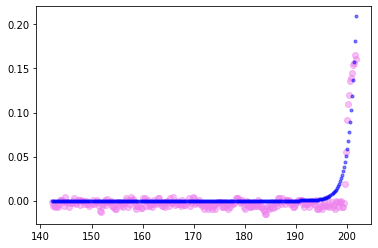

In [9]:
#front fit
xnew = [k for k in x if k < 202]
ynew = y[0:len(xnew)]


popt, pcov = curve_fit(func2, xnew, ynew, bounds=(0, [0.2, 3.55, 6.989001391e-25, 290]) )

plt.scatter(xnew,ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]
plt.plot(xnew, func2(np.array(xnew), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - front', color='blue');

popt

array([ 1.82080175e-01,  1.17919156e+00, -2.45604285e-03,  2.99223832e+02])

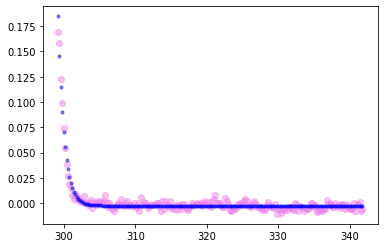

In [10]:
#tail fit
xnew = [k for k in x if k > 299]
ynew = y[len(y)-len(xnew):len(y)]

popt, pcov = curve_fit(func, xnew, ynew, bounds=([-0.005, 0.39894, -0.005, 290], [0.4, 1.5, 0, 310 ]) )

plt.scatter(xnew, ynew, alpha=0.5, color='violet')
plt.plot(xnew, func(np.array(xnew), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

# Gaussians fit for the PDA data and waveform

## Gaussian #1

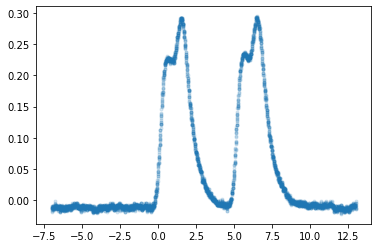

In [11]:
#waveform
i=4
x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y=(traces[i])[1]

plt.plot(x, y, '.', alpha=0.15, label='Switch and 3db attenuator');


array([ 0.04404656,  3.32387722, -0.01245426, -0.10956634])

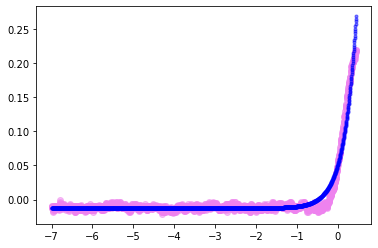

In [12]:
#front
xnew = [k for k in x if k < 0.45]
ynew = y[0:len(xnew)]

popt, pcov = curve_fit(func2, xnew, ynew, bounds=([0,0,-0.02,-0.5001], [0.2, 10,  -0.01, 0]) )

plt.scatter(xnew,ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]
plt.plot(xnew, func2(np.array(xnew), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - front', color='blue');

popt

array([ 8.79153921e-03,  1.52100207e+00, -1.10208997e-02,  9.00351734e+00])

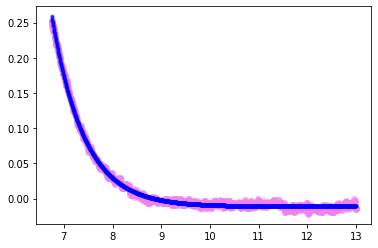

In [13]:
#tail
xnew = [k for k in x if k > 6.75]
ynew = y[len(y)-len(xnew):len(y)]

popt, pcov = curve_fit(func, xnew, ynew, bounds=([0,1.5,-0.02,9], [0.25, 2, -0.01, 9.1]) )

plt.scatter(xnew, ynew, alpha=0.5, color='violet')
plt.plot(xnew, func(np.array(xnew), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - front', color='blue');

popt

### Gaussian fit


array([ 0.29038557,  1.27363238,  0.804415  , -0.01001   ])

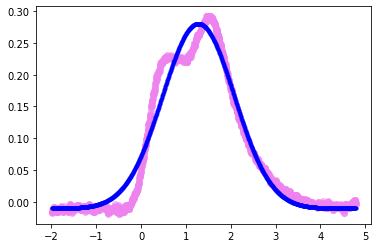

In [14]:
new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

popt, pcov = curve_fit(func3, xnew, ynew, bounds=([0, 0, 0, -0.01001], [ 2, 5, 2, -0.01]) )

plt.scatter(xnew, ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]
plt.plot(xnew, func3(np.array(xnew), popt[0],popt[1],popt[2],popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

## Gaussian #2

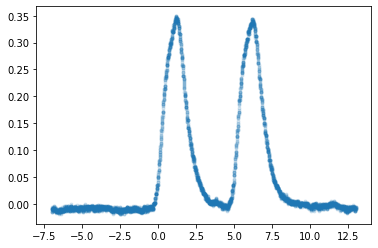

In [15]:
#waveform
i=5
x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y=(traces[i])[1]

plt.plot(x, y, '.', alpha=0.15, label='No Switch and 6db attenuator');


array([ 0.04166575,  3.31643552, -0.01065859, -0.11882147])

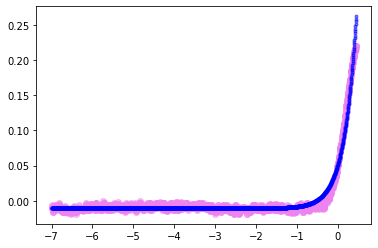

In [16]:
#front
xnew = [k for k in x if k < 0.45]
ynew = y[0:len(xnew)]

popt, pcov = curve_fit(func2, xnew, ynew, bounds=([0, 0, -0.02, -0.5001], [0.175, 4,  -0.005, 0]) ) 

plt.scatter(xnew,ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]
plt.plot(xnew, func2(np.array(xnew), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

array([ 0.19343201,  1.45      , -0.00692881,  6.79387134])

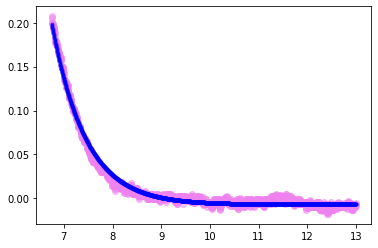

In [17]:
#tail
xnew = [k for k in x if k > 6.75]
ynew = y[len(y)-len(xnew):len(y)]

popt, pcov = curve_fit(func, xnew, ynew, bounds=([2.45e-2, 1.39, -0.01, -0.5001], [0.2, 1.45, -0.005, 8.1]) )


plt.scatter(xnew, ynew, alpha=0.5, color='violet')
plt.plot(xnew, func(np.array(xnew), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

### Gaussian fit


array([ 0.35071897,  1.13773624,  0.67644637, -0.01      ])

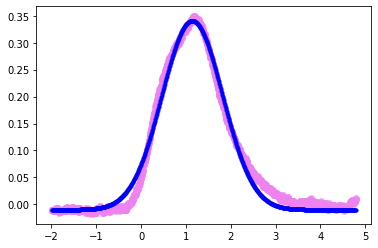

In [18]:
#Gaussian
new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

popt, pcov = curve_fit(func3, xnew, ynew, bounds=([0, 0, 0, -0.01001], [ 1, 2, 1, -0.01]) )

plt.scatter(xnew, ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]
plt.plot(xnew, func3(np.array(xnew), popt[0],popt[1],popt[2],popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

## Gaussian #3

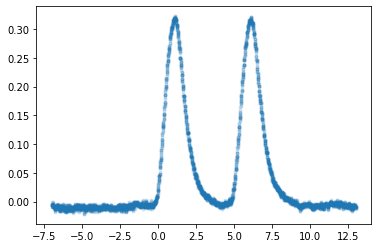

In [19]:
#waveform
i=6
x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y=(traces[i])[1]

plt.plot(x, y, '.', alpha=0.15, label='No Switch and 8db attenuator');


array([ 0.02933656,  3.72814893, -0.0101686 , -0.08407235])

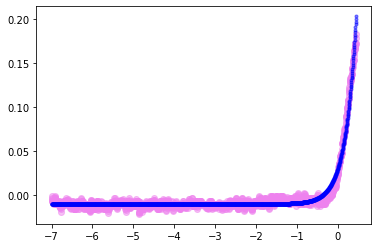

In [20]:
#front
xnew = [k for k in x if k < 0.45]
ynew = y[0:len(xnew)]

popt, pcov = curve_fit(func2, xnew, ynew, bounds=([0, 0, -0.02, -0.5001], [0.175, 4,  -0.005, 0]) ) 

plt.scatter(xnew,ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]
plt.plot(xnew, func2(np.array(xnew), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

array([ 0.19228708,  1.45      , -0.00837037,  6.63589929])

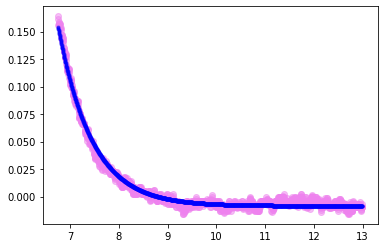

In [21]:
#tail
xnew = [k for k in x if k > 6.75]
ynew = y[len(y)-len(xnew):len(y)]

popt, pcov = curve_fit(func, xnew, ynew, bounds=([2.45e-2, 1.39, -0.01, -0.5001], [0.2, 1.45, -0.005, 8.1]) )


plt.scatter(xnew, ynew, alpha=0.5, color='violet')
plt.plot(xnew, func(np.array(xnew), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

### Gaussian fit


array([ 0.32364504,  1.10980322,  0.61197007, -0.01      ])

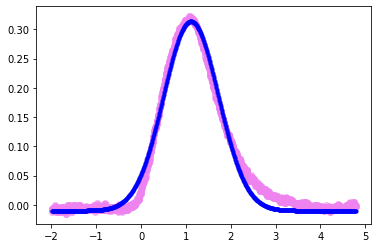

In [22]:
#Gaussian
new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

popt, pcov = curve_fit(func3, xnew, ynew, bounds=([0, 0, 0, -0.01001], [ 2, 3, 2, -0.01]) )

plt.scatter(xnew, ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]
plt.plot(xnew, func3(np.array(xnew), popt[0],popt[1],popt[2],popt[3]), '.', alpha=0.5, label='fit - back', color='blue');

popt

## Exponentially modified Gaussian distribution

Example with python of a fitted Exponentially modified Gaussian distribution

```Python

import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import exponnorm
import scipy.special as sse

data = [1.00733940e-09, 1.36882036e-08, 1.44555907e-07, 1.18647634e-06, 7.56926695e-06, 
        3.75417381e-05, 1.44836578e-04, 4.35259159e-04, 1.02249858e-03, 1.89480681e-03, 
        2.83377851e-03, 3.60624100e-03, 4.30392052e-03, 5.33527267e-03, 6.95313891e-03, 
        8.89175932e-03, 1.05631739e-02, 1.15411608e-02, 1.18087942e-02, 1.16473841e-02, 
        1.14907524e-02, 1.20296850e-02, 1.42949235e-02, 1.90939074e-02, 2.59260288e-02, 
        3.27250866e-02, 3.73294844e-02, 3.92476016e-02, 3.94803903e-02, 3.88736022e-02, 
        3.76397612e-02, 3.65042464e-02, 3.72842810e-02, 4.19404962e-02, 5.12185577e-02, 
        6.39393269e-02, 7.75139966e-02, 8.97085567e-02, 1.00200355e-01, 1.10354564e-01, 
        1.22123289e-01, 1.37876215e-01, 1.60232917e-01, 1.90218800e-01, 2.25749072e-01, 
        2.63342328e-01, 3.01468733e-01, 3.41685959e-01, 3.86769102e-01, 4.38219405e-01, 
        4.95491603e-01, 5.56936603e-01, 6.20721893e-01, 6.85160043e-01, 7.49797233e-01, 
        8.17175672e-01, 8.92232359e-01, 9.78276608e-01, 1.07437591e+00, 1.17877517e+00, 
        1.29376679e+00, 1.42302331e+00, 1.56366767e+00, 1.70593547e+00, 1.84278471e+00, 
        1.97546304e+00, 2.10659735e+00, 2.23148403e+00, 2.34113950e+00, 2.43414110e+00, 
        2.52261228e+00, 2.62487277e+00, 2.75168928e+00, 2.89831664e+00, 3.04838614e+00, 
        3.18625230e+00, 3.30842825e+00, 3.42373645e+00, 3.53943425e+00, 3.64686003e+00, 
        3.72464478e+00, 3.75656044e+00, 3.74189870e+00, 3.68666210e+00, 3.58686497e+00, 
        3.42241586e+00, 3.16910593e+00, 2.81976459e+00, 2.39676519e+00, 1.94507169e+00, 
        1.51241642e+00, 1.13287316e+00, 8.22421330e-01, 5.82858108e-01, 4.07338019e-01, 
        2.84100125e-01, 1.98750792e-01, 1.37317714e-01, 9.01427225e-02, 5.35761233e-02]


def mod_expGauss(x, l, s, m):
    return 0.5*l*np.exp(0.5*l*(2*m+l*s*s-2*x))*sse.erfc((m+l*s*s-x)/(np.sqrt(2)*s)) # exponential gaussian

popt,pcov=(curve_fit(mod_expGauss, np.linspace(0,1,100), data))
fitted_curve=list(mod_expGauss(np.linspace(0,1,100),popt[0],popt[1],popt[2]))
fitted_curve.reverse()
data.reverse()

plt.plot(fitted_curve)
plt.plot(data)

```

In [23]:
import scipy.special as sse

def mod_expGauss(x, a, l, s, m, c):
    return a*0.5*l*np.exp(0.5*l*(2*m+l*s*s-2*x))*sse.erfc((m+l*s*s-x)/(np.sqrt(2)*s)) + c# exponential gaussian


### Gaussian #1

array([ 0.62301794,  1.84318218,  0.70606242,  0.80851918, -0.01616609])

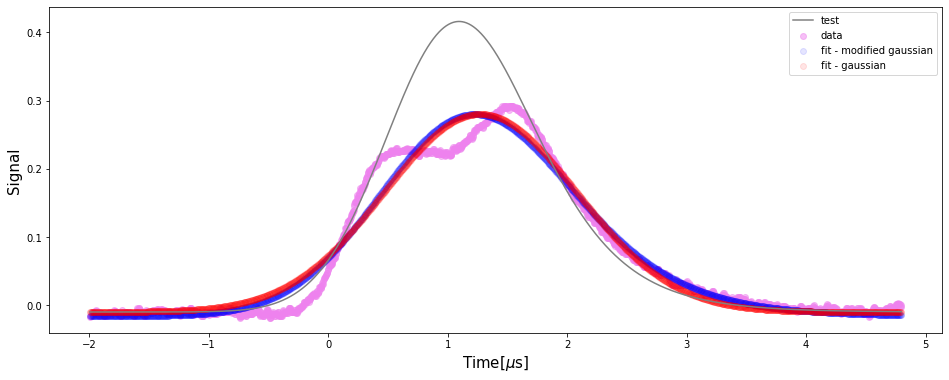

In [24]:
i=4
x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y=(traces[i])[1]

#Gaussian
new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

popt, pcov = curve_fit(mod_expGauss, xnew, ynew, bounds=([0.4,1.5,0,0,-0.2], [2, 2, 2, 1.5, -0.01]))

plt.figure(figsize=(16,6))
plt.scatter(xnew, ynew, alpha=0.5, color='violet', label='data')
plt.scatter(xnew, mod_expGauss(np.array(xnew), popt[0],popt[1],popt[2], popt[3], popt[4]), alpha=0.1, label='fit - modified gaussian', color='blue');
plt.scatter(xnew, func3(np.array(xnew), 0.29038557,  1.27363238,  0.804415  , -0.01001 ), alpha=0.1, label='fit - gaussian', color='red');

plt.plot(xnew, mod_expGauss(np.array(xnew), 0.7, 2.1, 0.53, 0.75, -0.01), color='gray', label='test')
plt.xlabel(r'Time[$\mu$s]', fontsize=15)
plt.ylabel(r'Signal', fontsize=15)
plt.legend()
popt


### Gaussian #2

array([ 0.61759488,  1.71409931,  0.52555922,  0.67441766, -0.01065735])

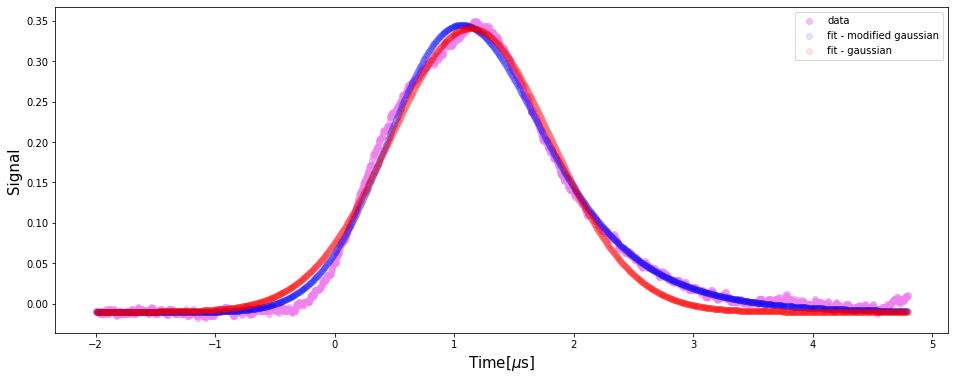

In [25]:
i=5
x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y=(traces[i])[1]

#Gaussian
new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

popt, pcov = curve_fit(mod_expGauss, xnew, ynew, p0=[ 0.6, 1.1, 0.38, 0.5, 0.01])

plt.figure(figsize=(16,6))
plt.scatter(xnew, ynew, alpha=0.5, color='violet', label='data')
plt.scatter(xnew, mod_expGauss(np.array(xnew), popt[0],popt[1],popt[2], popt[3], popt[4]), alpha=0.1, label='fit - modified gaussian', color='blue');
plt.scatter(xnew, func3(np.array(xnew), 0.35071897,  1.13773624,  0.67644637, -0.01  ), alpha=0.1, label='fit - gaussian', color='red');
plt.xlabel(r'Time[$\mu$s]', fontsize=15)
plt.ylabel(r'Signal', fontsize=15)
plt.legend()
popt


### Gaussian #3

array([ 0.50953889,  1.7195035 ,  0.44096689,  0.66413314, -0.00777824])

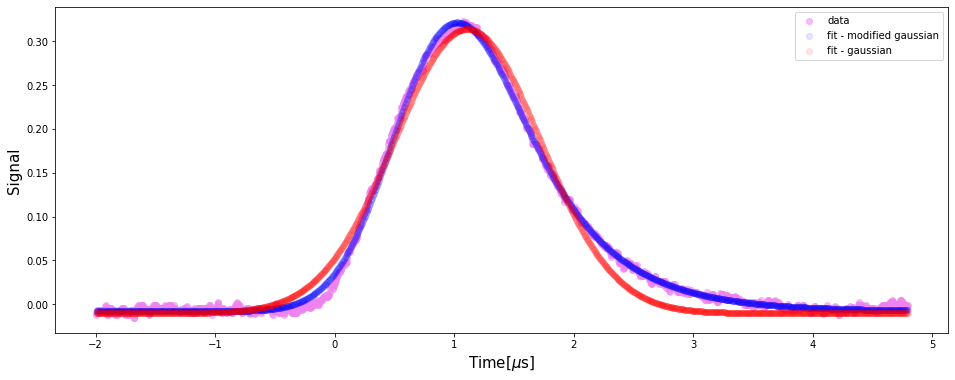

In [26]:
i=6
x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y=(traces[i])[1]

#Gaussian
new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

popt, pcov = curve_fit(mod_expGauss, xnew, ynew, p0=[ 0.6, 1.1, 0.38, 0.5, 0])

plt.figure(figsize=(16,6))
plt.scatter(xnew, ynew, alpha=0.5, color='violet', label='data')
plt.scatter(xnew, mod_expGauss(np.array(xnew), popt[0],popt[1],popt[2], popt[3], popt[4]), alpha=0.1, label='fit - modified gaussian', color='blue');
plt.scatter(xnew, func3(np.array(xnew), 0.32364504,  1.10980322,  0.61197007, -0.01  ), alpha=0.1, label='fit - gaussian', color='red');
plt.legend()
plt.xlabel(r'Time[$\mu$s]', fontsize=15)
plt.ylabel(r'Signal', fontsize=15)
popt


---

# Summary

| Signal/Fitting | Exponential (+) {a,b,xo,c} | Exponential (-) {a,b,xo,c} | Gaussian {a, mu, sigma, c} | Modified Gaussian {a, l, s, m, c} |
| --- | --- | --- | --- | --- |
| #1 | {0.04404656,  3.32387722, -0.01245426, -0.10956634} | {8.79153921e-03,  1.52100207e+00, -1.10208997e-02,  9.00351734e+00} | {0.29038557,  1.27363238,  0.804415  , -0.01001} | {0.62301794,  1.84318218,  0.70606242,  0.80851918, -0.01616609} |
| #2 | {0.04166575,  3.31643552, -0.01065859, -0.11882147} | {0.19343201,  1.45      , -0.00692881,  6.79387134} | {0.35071897,  1.13773624,  0.67644637, -0.01} | {0.61759488,  1.71409931,  0.52555922,  0.67441766, -0.01065735} |
| #3 | {0.02933656,  3.72814893, -0.0101686 , -0.08407235} | {0.19228708,  1.45      , -0.00837037,  6.63589929} | {0.32364504,  1.10980322,  0.61197007, -0.01 } | {0.50953889,  1.7195035 ,  0.44096689,  0.66413314, -0.00777824} |

In [27]:
x_lst=[];
for i in [4,5,6]:
    x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
    
    if i==4:
        new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
    if i==5:
        new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
    if i==6:
        new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
    
    x_lst.append(np.array(x)[new_idx])

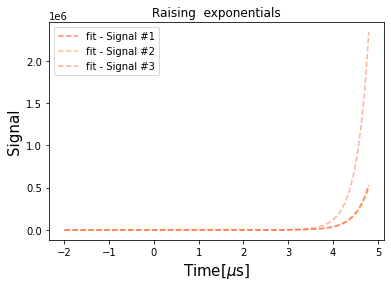

In [28]:
#ascending exponentials
plt.plot(x_lst[0], func2(np.array(xnew), 0.04404656,  3.32387722, -0.01245426, -0.10956634), '--', alpha=0.5, label='fit - Signal #1', color='red');
plt.plot(x_lst[1], func2(np.array(xnew), 0.04166575,  3.31643552, -0.01065859, -0.11882147), '--', alpha=0.5, label='fit - Signal #2', color='darkorange');
plt.plot(x_lst[2], func2(np.array(xnew), 0.02933656,  3.72814893, -0.0101686 , -0.08407235), '--', alpha=0.5, label='fit - Signal #3', color='tomato');
plt.legend();
plt.title('Raising  exponentials')
plt.xlabel(r'Time[$\mu$s]', fontsize=15);
plt.ylabel(r'Signal', fontsize=15);

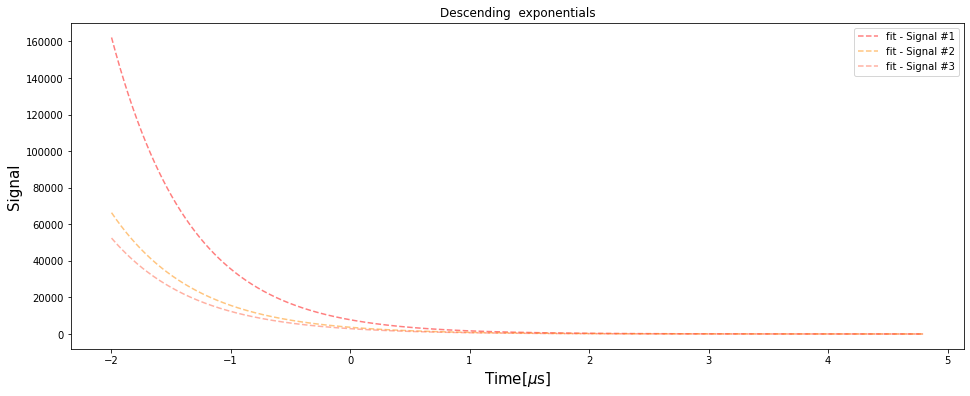

In [29]:
#descending exponentials
plt.figure(figsize=(16,6))

plt.plot(x_lst[0], func(np.array(xnew), 8.79153921e-03,  1.52100207e+00, -1.10208997e-02,  9.00351734e+00), '--', alpha=0.5, label='fit - Signal #1', color='red');
plt.plot(x_lst[1], func(np.array(xnew), 0.19343201,  1.45      , -0.00692881,  6.79387134), '--', alpha=0.5, label='fit - Signal #2', color='darkorange');
plt.plot(x_lst[2], func(np.array(xnew), 0.19228708,  1.45      , -0.00837037,  6.63589929), '--', alpha=0.5, label='fit - Signal #3', color='tomato');
plt.legend();
plt.title('Descending  exponentials')
plt.xlabel(r'Time[$\mu$s]', fontsize=15);
plt.ylabel(r'Signal', fontsize=15);

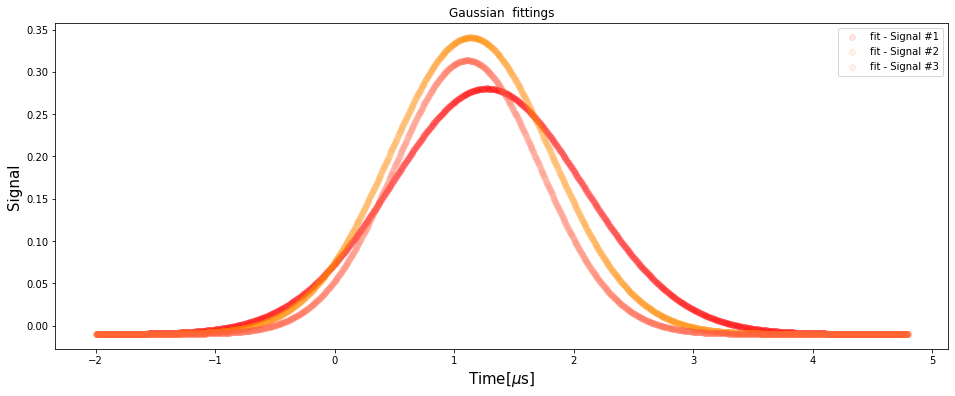

In [30]:
#gaussian fits
plt.figure(figsize=(16,6))


plt.scatter(x_lst[0], func3(np.array(x_lst[0]), 0.29038557,  1.27363238,  0.804415  , -0.01001 ), alpha=0.1, label='fit - Signal #1', color='red');
plt.scatter(x_lst[1], func3(np.array(x_lst[1]), 0.35071897,  1.13773624,  0.67644637, -0.01  ), alpha=0.1, label='fit - Signal #2', color='darkorange');
plt.scatter(x_lst[2], func3(np.array(x_lst[2]), 0.32364504,  1.10980322,  0.61197007, -0.01  ), alpha=0.1, label='fit - Signal #3', color='tomato');
plt.legend();
plt.title('Gaussian  fittings')
plt.xlabel(r'Time[$\mu$s]', fontsize=15);
plt.ylabel(r'Signal', fontsize=15);

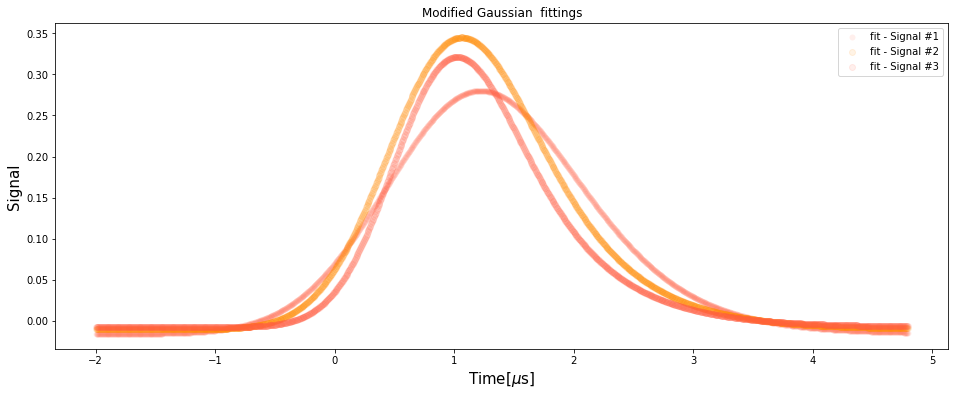

In [31]:
#modified gaussian fits
plt.figure(figsize=(16,6))


plt.scatter(x_lst[0], mod_expGauss(np.array(x_lst[0]), 0.62301794,  1.84318218,  0.70606242,  0.80851918, -0.01616609), alpha=0.1, label='fit - Signal #1', color='tomato', linewidths=1e-3);
plt.scatter(x_lst[1], mod_expGauss(np.array(x_lst[1]), 0.61759488,  1.71409931,  0.52555922,  0.67441766, -0.01065735), alpha=0.1, label='fit - Signal #2', color='darkorange');
plt.scatter(x_lst[2], mod_expGauss(np.array(x_lst[2]), 0.50953889,  1.7195035 ,  0.44096689,  0.66413314, -0.00777824), alpha=0.1, label='fit - Signal #3', color='tomato');
plt.legend();
plt.title('Modified Gaussian  fittings');
plt.xlabel(r'Time[$\mu$s]', fontsize=15);
plt.ylabel(r'Signal', fontsize=15);

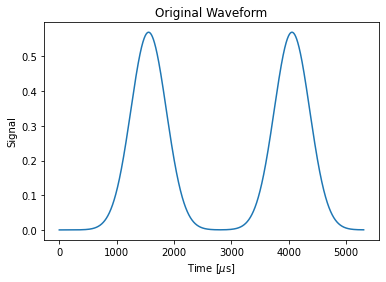

In [32]:
import pandas as pd
df=pd.read_csv('waveforms_files/20211201/newgussiandelay6.csv')

wf = [float(df.values[k][0]) for k in range(4,len(df.values))]

plt.plot(wf)
plt.title('Original Waveform');
plt.xlabel('Time [$\mu$s]');
plt.ylabel('Signal');

(-0.1, 0.6)

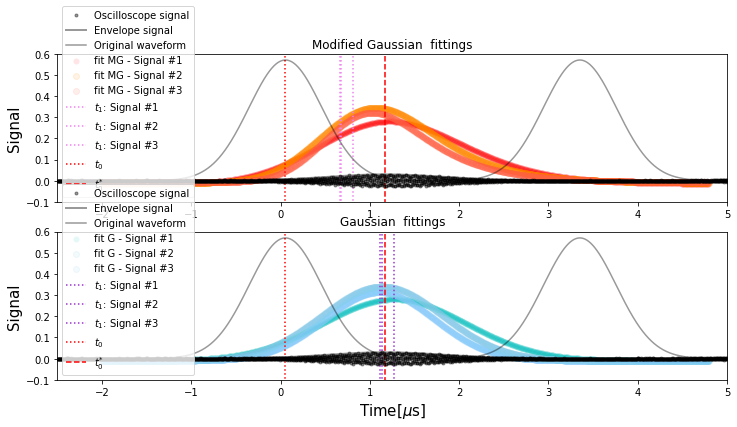

In [33]:
#modified gaussian fits
f, [ax1,ax2] = plt.subplots(2,1,figsize=(12,6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

i=7
x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y=(traces[i])[1]
new_idx=(np.array(x) > -2.) & (np.array(x) < 4.8);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];


# args = {'mean':-0.3,  'std': 0.7, 'name':'gaussian-aqipt', 'color':'green'}
# func, plot = aqipt.function(x_lst[0], args).gaussian4STIRAP()

#MG (modified gaussian)
ax1.scatter(x_lst[0], mod_expGauss(np.array(x_lst[0]), 0.62301794,  1.84318218,  0.70606242,  0.80851918, -0.01616609), alpha=0.1, label='fit MG - Signal #1', color='red', linewidths=1e-3);
ax1.scatter(x_lst[1], mod_expGauss(np.array(x_lst[1]), 0.61759488,  1.71409931,  0.52555922,  0.67441766, -0.01065735), alpha=0.1, label='fit MG - Signal #2', color='darkorange');
ax1.scatter(x_lst[2], mod_expGauss(np.array(x_lst[2]), 0.50953889,  1.7195035 ,  0.44096689,  0.66413314, -0.00777824), alpha=0.1, label='fit MG - Signal #3', color='tomato');
#vertical lines for MG
ax1.vlines(x=0.80851918, ymin=-0.6, ymax=0.6, color='violet', linestyles='dotted', label=r'$t_1$: Signal #1');
ax1.vlines(x=0.67441766, ymin=-0.6, ymax=0.6, color='violet', linestyles='dotted', label=r'$t_1$: Signal #2');
ax1.vlines(x=0.664133141, ymin=-0.6, ymax=0.6, color='violet', linestyles='dotted', label=r'$t_1$: Signal #3');


#wf
ax1.plot(x, y, '.',label='Oscilloscope signal', color='black', alpha=0.4)
ax1.plot(x, func3(np.array(x), 3.00000000e-002, 1.17021746e+000, 6.50000000e-001, 2.56946619e-114), alpha=0.4, label='Envelope signal', color='black', linewidth=2);
ax1.plot(np.linspace(-2,5, 5309), wf, label='Original waveform', color='black', alpha=0.4)
#vertical lines for wf
ax1.vlines(x=1.375-1.25-0.075, ymin=-0.6, ymax=0.6, color='red', linestyles='dotted', label=r'$t_0$'); #original wf
ax1.vlines(x=1.17021746, ymin=-0.6, ymax=0.6, color='red', linestyles='dashed', label=r'$t_{0}^{*}$'); #oscilloscope wf

ax1.set_title('Modified Gaussian  fittings');
ax1.set_ylabel(r'Signal', fontsize=15);
# ax1.grid();
ax1.legend(loc=3);
ax1.set_xlim(-2.5,5);
ax1.set_ylim(-0.1, 0.6)


#-----#


#G (gaussian)
ax2.scatter(x_lst[0], func3(np.array(x_lst[0]), 0.29038557,  1.27363238,  0.804415  , -0.01001 ), alpha=0.1, label='fit G - Signal #1', color='c', linewidths=1e-3);
ax2.scatter(x_lst[1], func3(np.array(x_lst[1]), 0.35071897,  1.13773624,  0.67644637, -0.01  ), alpha=0.1, label='fit G - Signal #2', color='skyblue');
ax2.scatter(x_lst[2], func3(np.array(x_lst[2]), 0.32364504,  1.10980322,  0.61197007, -0.01  ), alpha=0.1, label='fit G - Signal #3', color='lightskyblue');
#vertical lines for G
ax2.vlines(x=1.27363238, ymin=-0.6, ymax=0.6, color='darkorchid', linestyles='dotted', label=r'$t_1$: Signal #1');
ax2.vlines(x=1.13773624, ymin=-0.6, ymax=0.6, color='darkorchid', linestyles='dotted', label=r'$t_1$: Signal #2');
ax2.vlines(x=1.10980322, ymin=-0.6, ymax=0.6, color='darkorchid', linestyles='dotted', label=r'$t_1$: Signal #3');


#wf
ax2.plot(x, y, '.',label='Oscilloscope signal', color='black', alpha=0.4)
ax2.plot(x, func3(np.array(x), 3.00000000e-002, 1.17021746e+000, 6.50000000e-001, 2.56946619e-114), alpha=0.4, label='Envelope signal', color='black', linewidth=2);
ax2.plot(np.linspace(-2,5, 5309), wf, label='Original waveform', color='black', alpha=0.4)
#vertical lines for wf
ax2.vlines(x=1.375-1.25-0.075, ymin=-0.6, ymax=0.6, color='red', linestyles='dotted', label=r'$t_0$'); #original wf
ax2.vlines(x=1.17021746, ymin=-0.6, ymax=0.6, color='red', linestyles='dashed', label=r'$t_{0}^{*}$'); #oscilloscope wf

ax2.set_title('Gaussian  fittings');
ax2.set_xlabel(r'Time[$\mu$s]', fontsize=15);
ax2.set_ylabel(r'Signal', fontsize=15);
# plt.grid();
ax2.legend(loc=3);

ax2.set_xlim(-2.5,5);
# ax2.xlim(-0.5,3)
ax2.set_ylim(-0.1, 0.6)

# Nanosecond waforms for stirap

In [34]:
#Shuzhe gaussians
def gaussian4STIRAP(tbase, args, plotON=False):
            '''
                Basic Gaussian function

                INPUTS
                    t (array): time domain of function
                    args (dict): width of step function (i.e., standard deviation,center)
                    plotON (bool): shows (True) or not (False) plot

                OUTPUTS
                    function: function ready for aqipt.waveform()
                    fig: plot of function

                \Example:

                    times = np.linspace(-75, 75, 500); #time domain function

                    args = {'a':1, 'b': 0, 'c':0, 'shift':0}; #arguments for function

                    f, fplot = gaussian4STIRAP(times, args);
                    plt.show(fplot)

            '''

            k=np.linspace(args["mean"], args["mean"]+191*2*2, 192)
            
            result=0
            
            for i in k:
                result=result+1/(args["std"]*np.sqrt(2*np.pi))*np.exp(-(tbase-i)**2/args["std"]**2);
          
            
            function = result



            if plotON==True:

                fig = plt.figure();
                fplot = plt.scatter(tbase, function, figure=fig);
                plt.show(fplot)

                return function, fplot

            else:

                return function, plt.scatter(tbase, function, s=1, color='red')

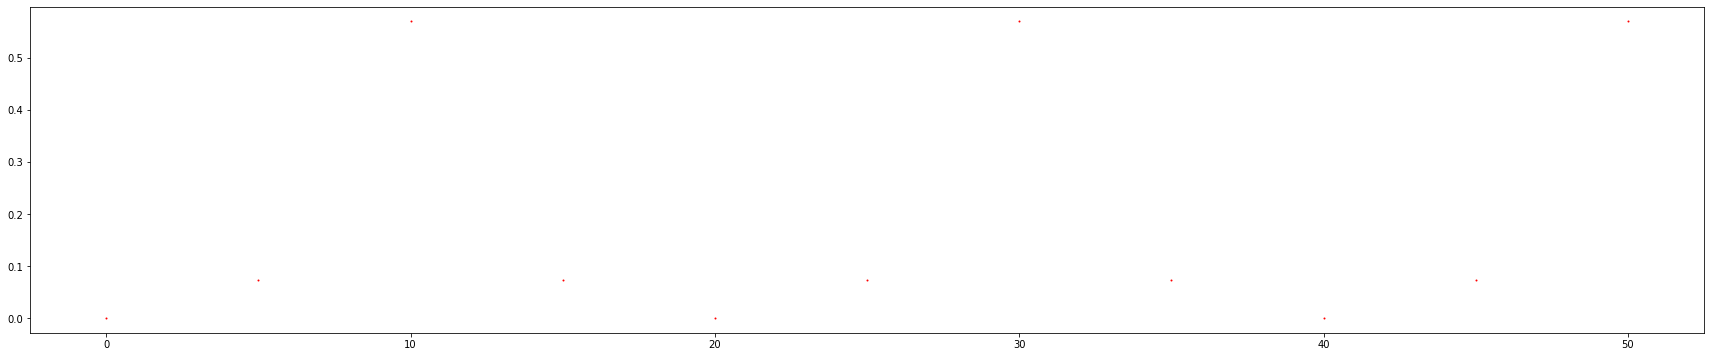

In [78]:
freq= 0.5
point= (5/freq)+1
args = {'sampling':int(1*point), 'bitdepth':16, 'time_dyn':50};
params = aqipt.general_params(args); #get params AQiPT object from dictionary
tbase = params.timebase(); #obtain time-base from params object

args_lst={'mean':2, 'std':0.7,'name': 'newgussian22', 'color': 'red'}

plt.figure(figsize=(30,6));
func, pt = gaussian4STIRAP(tbase, args_lst, plotON=False)
# plt.xlim(0,50);

In [36]:
len(tbase)

11

In [37]:
point

11.0

In [38]:
tbase

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

---

In [39]:
#Manuel gaussians for STIRAP
def STIRAP_gaussian(tbase, args, plotON=False):
            '''
                Basic Gaussian function

                INPUTS
                    t (array): time domain of function
                    args (dict): width of step function (i.e., standard deviation,center)
                    plotON (bool): shows (True) or not (False) plot

                OUTPUTS
                    function: function ready for aqipt.waveform()
                    fig: plot of function

                \Example:

                    times = np.linspace(-75, 75, 500); #time domain function

                    args = {'a':1, 'b': 0, 'c':0, 'shift':0}; #arguments for function

                    f, fplot = gaussian4STIRAP(times, args);
                    plt.show(fplot)

            '''

            
            function = args["gain"]*1/(args["std"]*np.sqrt(2*np.pi))*np.exp(-(tbase-args["mean"])**2/args["std"]**2)



            if plotON==True:

                fig = plt.figure();
                fplot = plt.stem(tbase, function, figure=fig);
                plt.show(fplot)

                return function, fplot

            else:

                return function, plt.stem(tbase, function)

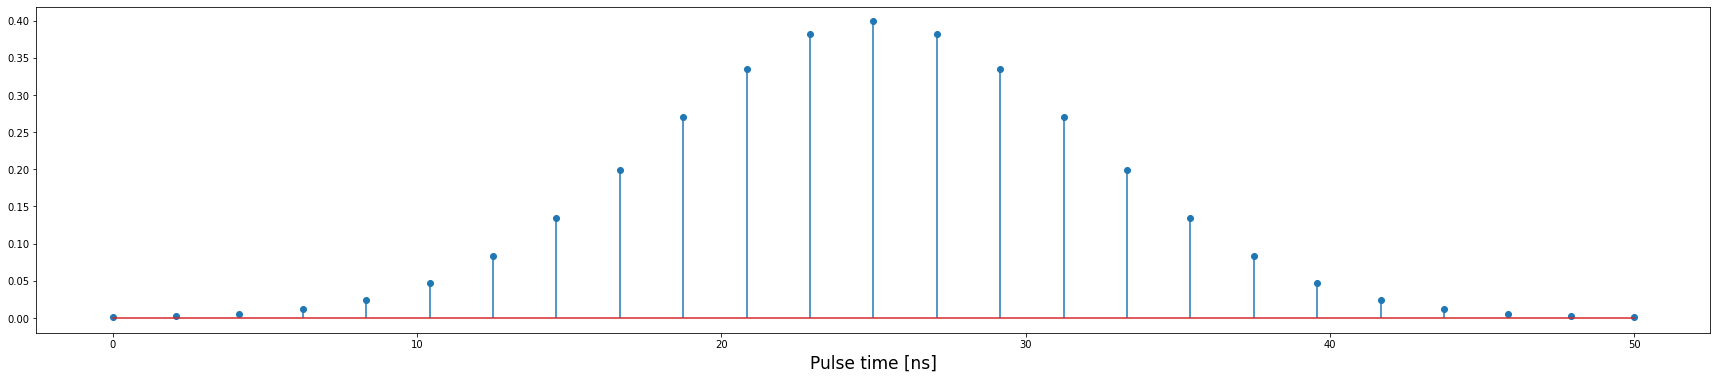

In [40]:
spns = 0.5
res = 1/spns
pulse_time = 50.0

nr_points = pulse_time/res

args = {'sampling':round(nr_points), 'bitdepth':16, 'time_dyn':pulse_time};
params = aqipt.general_params(args); #get params AQiPT object from dictionary
tbase = params.timebase(); #obtain time-base from params object

args_lst={'mean':25, 'std':10, 'gain':10,'name': 'gaussian_50ns', 'color': 'blue'}

plt.figure(figsize=(30,6)); 
func, pt = STIRAP_gaussian(tbase, args_lst, plotON=False)
plt.xlabel(r'Pulse time [ns]', fontsize=17);
# plt.legend()
# plt.xlim(0,4);

In [41]:
print('Sampling rate:', spns, 'samples/ns')
print('Resolution:', res, 'ns')
print('Number of points:', nr_points, 'points/t_pulse')

Sampling rate: 0.5 samples/ns
Resolution: 2.0 ns
Number of points: 25.0 points/t_pulse


<StemContainer object of 3 artists>

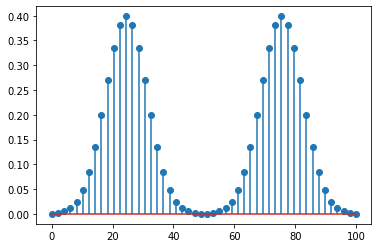

In [42]:
#concatenating pulses
plt.stem(np.linspace(0,int(pulse_time)*2,int(nr_points)*2), np.concatenate([func, func]))

In [43]:
pulse_time

50.0

# Benchmark pulses

The number of samples of the AWG is set in 500MS/s for the Keysight M3201A. This represents a resolution of 2ns, i.e., time between points (samples). For the DUT (AOM) we estimate the value of the bandwidth in 6MHz, which represent a narrowest pulse possible pulse of 166ns, with 83samples(points). However, according to the AWG manual, there is a dependency of the time between when the waveform is played and the trigger time, on the number/lenght of the waveform. 

<img src="resources/pulse_sync.png" style="width:800px;height:400px;">

So then we benchmark different pulse times with different number of points in other to see a higher or lower effect of the deformation of the pulse due to the electronics and the rest of the experiment.

Test | Pulse time | # of points | 
--- | --- | --- | 
#1 | 166ns | 83 |
|  | 40 |
|  | 16 |
--- | --- | --- | 
#2 | 500ns | 250 |
|  | 120 |
|  | 50 |
--- | --- | --- | 
#3 | 800ns | 400 |
|  | 200 |
|  | 80 |

## 166ns

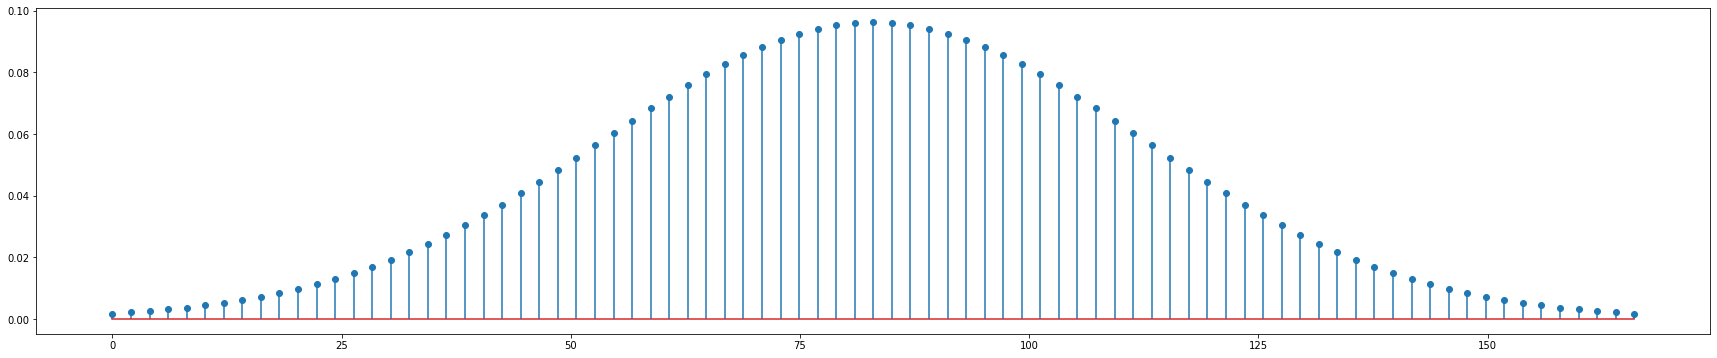

In [44]:
#gaussian 166ns, 83 points, centered in 83ns, stdev 41.5ns, gain 10
spns = 0.5
res = 1/spns
pulse_time = 166.0

nr_points = pulse_time/res

args = {'sampling':round(nr_points), 'bitdepth':16, 'time_dyn':pulse_time};
params = aqipt.general_params(args); #get params AQiPT object from dictionary
tbase = params.timebase(); #obtain time-base from params object

args_lst={'mean':pulse_time/2, 'std':pulse_time/4, 'gain':10,'name': 'gaussian_166ns', 'color': 'blue'}

plt.figure(figsize=(30,6));
gaussian_166ns, pt = aqipt.function(tbase, args_lst).STIRAP_gaussian(plotON=False)
# plt.xlim(0,50);

## 500ns

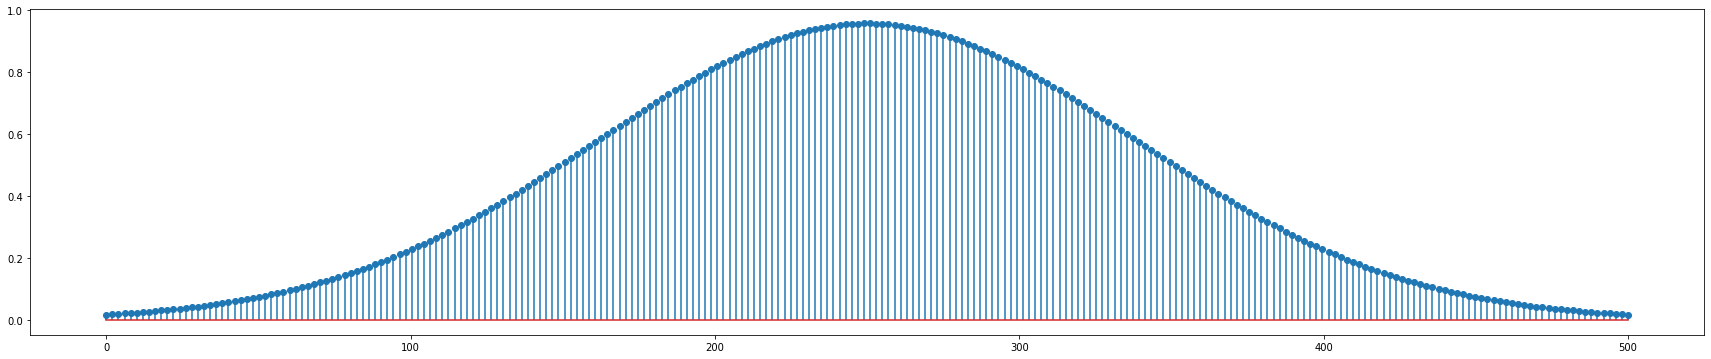

In [45]:
#gaussian 500ns, 250 points, centered in 250ns, stdev 125ns, gain 10
spns = 0.5
res = 1/spns
pulse_time = 500.0

nr_points = pulse_time/res

args = {'sampling':round(nr_points), 'bitdepth':16, 'time_dyn':pulse_time};
params = aqipt.general_params(args); #get params AQiPT object from dictionary
tbase = params.timebase(); #obtain time-base from params object

args_lst={'mean':pulse_time/2, 'std':pulse_time/4, 'gain':3e2,'name': 'gaussian_500ns', 'color': 'blue'}

plt.figure(figsize=(30,6));
gaussian_500ns, pt = aqipt.function(tbase, args_lst).STIRAP_gaussian(plotON=False)
# plt.xlim(0,50);

## 800ns

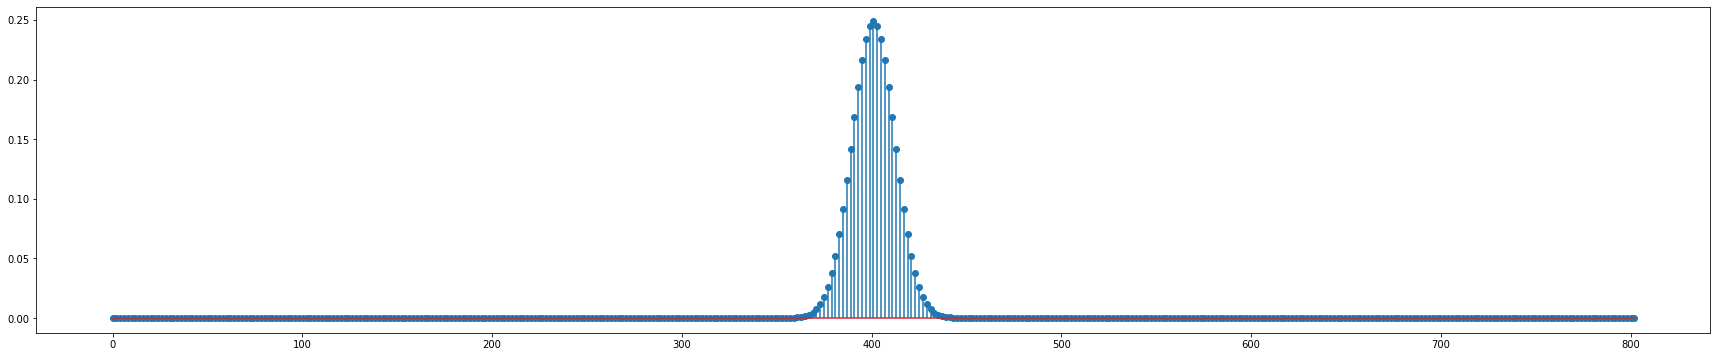

In [71]:
#gaussian 800ns, 400 points, centered in 400ns, stdev 200ns, gain 10
spns = 0.5
res = 1/spns
pulse_time = 802.0

nr_points = pulse_time/res

args = {'sampling':round(nr_points), 'bitdepth':16, 'time_dyn':pulse_time};
params = aqipt.general_params(args); #get params AQiPT object from dictionary
tbase = params.timebase(); #obtain time-base from params object

args_lst={'mean':pulse_time/2, 'std':pulse_time/50, 'gain':0.1e2,'name': 'gaussian_50ns', 'color': 'blue'}

plt.figure(figsize=(30,6));
gaussian_800ns, pt = aqipt.function(tbase, args_lst).STIRAP_gaussian(plotON=False)


# Response and decay time dependency from PDA Gain

First we test a square pulse with different gains of the PDA, this because at the moment we have the following latencies, due to the different components. 

Test | Device | Time(ns) | 
--- | --- | --- | 
#1 | Switch | 20 |
#2 | Amplifier| 20|
#3 | AOM| 25|
#4 | PDA| 63|
#5 | Oscilloscope| 7|


Considering this, we can extract the kernel of the convolution of the system such that we can correct pulses from the distorsions of the hardware.


In [47]:
#read csv
fname = 'oscilloscope_acq/20211210_oscilloscope_gain_APD/scope_'
nr_files = 4
traces_fromPDA = oscReadout(fname, nr_files)


1002
1002
1002
1002


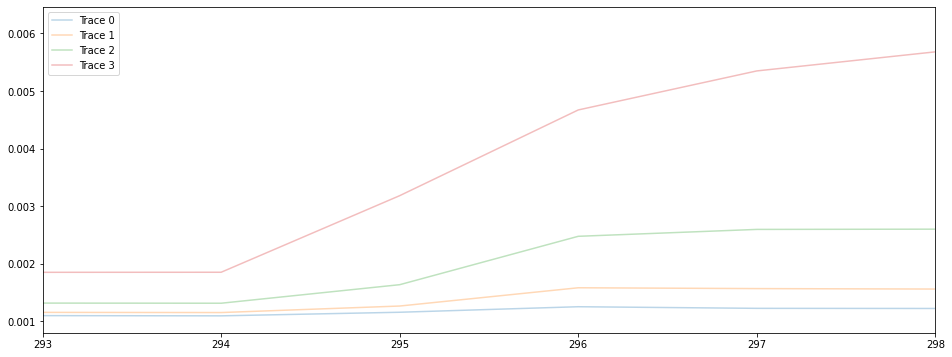

In [547]:
plt.figure(figsize=(16,6))
i=0;
for trace in traces_fromPDA:
    plt.plot( (traces_fromPDA[i])[1], '-', alpha=0.3, label='Trace '+str(i));
    i+=1;
    
plt.xlim(293, 298)
plt.legend()

## 10 dB

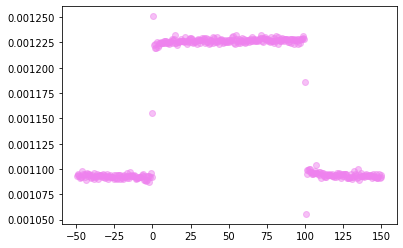

In [49]:
i=0
x=[((traces_fromPDA[i])[0])[k]/1e-6 for k in range(len(((traces_fromPDA[i])[0])))]
y=(traces_fromPDA[i])[1]

#Gaussian
new_idx=(np.array(x) > -50) & (np.array(x) < 150);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

plt.scatter(xnew,ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]


array([1.25732446e-03, 2.43448517e+00, 1.09149790e-03, 1.28026613e+00])

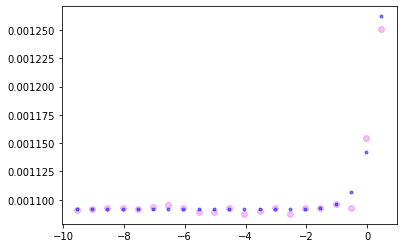

In [50]:
#front
new_idx=(np.array(xnew) > -10) & (np.array(xnew) < 0.5);
xnew_cut = xnew[new_idx]
ynew_cut = ynew[new_idx]

popt, pcov = curve_fit(func2, xnew_cut, ynew_cut, bounds=([ 0.0012, 0, 0.00105, 0], [ 0.0013, 6, 0.00115, 3]) ) 

plt.scatter(xnew_cut,ynew_cut, alpha=0.5, color='violet')
plt.plot(xnew_cut, func2(np.array(xnew_cut), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');
# plt.plot(xnew_cut, func2(np.array(xnew_cut), 1e-3, 3.2, 0.00109, 1 ), '.', alpha=0.5, label='fit - back', color='red');

popt

In [548]:
#tail fit
new_idx=(np.array(xnew) > 99) & (np.array(xnew) < 125);
xnew_cut = xnew[new_idx]
ynew_cut = ynew[new_idx]

popt, pcov = curve_fit(func, xnew_cut, ynew_cut, bounds=([ 0, 0, 0, 92], [ 1.225e-3, 2, 0.0011, 102]) ) 

plt.scatter(xnew_cut,ynew_cut, alpha=0.5, color='violet') 
plt.plot(xnew_cut, func(np.array(xnew_cut), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');
# plt.plot(xnew_cut, func(np.array(xnew_cut), 1.225e-3, 0.1, 0.0011, 100), '.', alpha=0.5, label='fit - back', color='red');

popt

TypeError: array([1.62386884e-04, 7.40451798e-02, 5.69917543e-01, 7.40451798e-02,
       3.24773769e-04, 7.40451798e-02, 5.69917543e-01, 7.40451798e-02,
       3.24773769e-04, 7.40451798e-02, 5.69917543e-01]) is not a callable object

## 20 dB

In [ ]:
i=1
x=[((traces_fromPDA[i])[0])[k]/1e-6 for k in range(len(((traces_fromPDA[i])[0])))]
y=(traces_fromPDA[i])[1]

#Gaussian
new_idx=(np.array(x) > -50) & (np.array(x) < 150);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

plt.scatter(xnew,ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]


In [ ]:
#front
new_idx=(np.array(xnew) > -10) & (np.array(xnew) < 0.5);
xnew_cut = xnew[new_idx]
ynew_cut = ynew[new_idx]

popt, pcov = curve_fit(func2, xnew_cut, ynew_cut, bounds=([ 0.0012, 0, 0.00105, 0], [ 0.0013, 6, 0.00115, 3]) ) 

plt.scatter(xnew_cut,ynew_cut, alpha=0.5, color='violet')
plt.plot(xnew_cut, func2(np.array(xnew_cut), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');
# plt.plot(xnew_cut, func2(np.array(xnew_cut), 0.006, 3.2, 0.002, 0 ), '.', alpha=0.5, label='fit - back', color='red');

popt

In [ ]:
#tail fit
new_idx=(np.array(xnew) > 99) & (np.array(xnew) < 125);
xnew_cut = xnew[new_idx]
ynew_cut = ynew[new_idx]

popt, pcov = curve_fit(func, xnew_cut, ynew_cut, bounds=([ 0, 0, 0, 92], [ 1.225e-3, 2, 0.011, 102]) ) 

plt.scatter(xnew_cut,ynew_cut, alpha=0.5, color='violet') 
plt.plot(xnew_cut, func(np.array(xnew_cut), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');
# plt.plot(xnew_cut, func(np.array(xnew_cut), 1.225e-3, 0.1, 0.0011, 100), '.', alpha=0.5, label='fit - back', color='red');

popt

## 30 dB

In [ ]:
i=2
x=[((traces_fromPDA[i])[0])[k]/1e-6 for k in range(len(((traces_fromPDA[i])[0])))]
y=(traces_fromPDA[i])[1]

#Gaussian
new_idx=(np.array(x) > -50) & (np.array(x) < 150);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

plt.scatter(xnew,ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]


In [ ]:
#front
new_idx=(np.array(xnew) > -10) & (np.array(xnew) < 0.5);
xnew_cut = xnew[new_idx]
ynew_cut = ynew[new_idx]

popt, pcov = curve_fit(func2, xnew_cut, ynew_cut, bounds=([ 0.0012, 0, 0.00132, 0], [ 0.0013, 7, 0.0015, 3])) 

plt.scatter(xnew_cut,ynew_cut, alpha=0.5, color='violet')
plt.plot(xnew_cut, func2(np.array(xnew_cut), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');
# plt.plot(xnew_cut, func2(np.array(xnew_cut), 1e-3, 3.2, 0.00109, 1 ), '.', alpha=0.5, label='fit - back', color='red');

popt

In [ ]:
#tail fit
new_idx=(np.array(xnew) > 99) & (np.array(xnew) < 125);
xnew_cut = xnew[new_idx]
ynew_cut = ynew[new_idx]

popt, pcov = curve_fit(func, xnew_cut, ynew_cut, bounds=([ 0, 0, 0, 92], [ 1.225e-3, 2, 0.011, 102]) ) 

plt.scatter(xnew_cut,ynew_cut, alpha=0.5, color='violet') 
plt.plot(xnew_cut, func(np.array(xnew_cut), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');
# plt.plot(xnew_cut, func(np.array(xnew_cut), 1.225e-3, 0.1, 0.0011, 100), '.', alpha=0.5, label='fit - back', color='red');

popt

## 40 dB

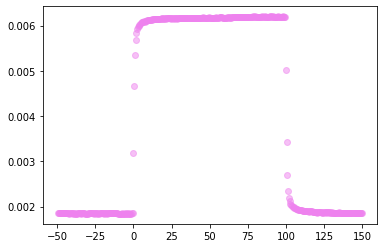

In [52]:
i=3
x=[((traces_fromPDA[i])[0])[k]/1e-6 for k in range(len(((traces_fromPDA[i])[0])))]
y=(traces_fromPDA[i])[1]

#Gaussian
new_idx=(np.array(x) > -50) & (np.array(x) < 150);
xnew = np.array(x)[new_idx];
ynew = np.array(y)[new_idx];

plt.scatter(xnew,ynew, alpha=0.5, color='violet') #[y*10e11 for y in ynew]


array([3.48463111e-03, 3.00039604e+00, 1.86176800e-03, 5.15943582e-01])

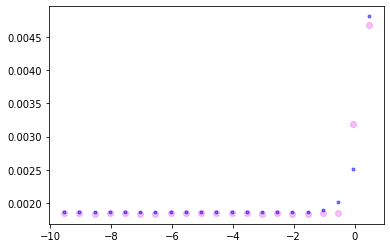

In [53]:
#front
new_idx=(np.array(xnew) > -10) & (np.array(xnew) < 0.5);
xnew_cut = xnew[new_idx]
ynew_cut = ynew[new_idx]

popt, pcov = curve_fit(func2, xnew_cut, ynew_cut, bounds=([ 0.0015, 3, 0.0017, 0], [ 0.0056, 10, 0.002, 1]) ) 

plt.scatter(xnew_cut,ynew_cut, alpha=0.5, color='violet')
plt.plot(xnew_cut, func2(np.array(xnew_cut), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');
# plt.plot(xnew_cut, func2(np.array(xnew_cut), 1e-3, 3.2, 0.00109, 1 ), '.', alpha=0.5, label='fit - back', color='red');

popt

In [54]:
#tail fit
new_idx=(np.array(xnew) > 99) & (np.array(xnew) < 125);
xnew_cut = xnew[new_idx]
ynew_cut = ynew[new_idx]

popt, pcov = curve_fit(func, xnew_cut, ynew_cut, bounds=([ 0, 0, 0, 92], [ 1.225e-3, 2, 0.011, 102]) ) 

plt.scatter(xnew_cut,ynew_cut, alpha=0.5, color='violet') 
plt.plot(xnew_cut, func(np.array(xnew_cut), popt[0],popt[1],popt[2], popt[3]), '.', alpha=0.5, label='fit - back', color='blue');
# plt.plot(xnew_cut, func(np.array(xnew_cut), 1.225e-3, 0.1, 0.0011, 100), '.', alpha=0.5, label='fit - back', color='red');

popt

TypeError: array([0.00077014, 0.00208983, 0.00519938, 0.01186024, 0.02480484,
       0.04756421, 0.08362284, 0.13479395, 0.19921254, 0.26993785,
       0.33536035, 0.38199746, 0.39894228, 0.38199746, 0.33536035,
       0.26993785, 0.19921254, 0.13479395, 0.08362284, 0.04756421,
       0.02480484, 0.01186024, 0.00519938, 0.00208983, 0.00077014]) is not a callable object

## Summary response time

Text(0, 0.5, '$\\tau_{r}$ [ns]')

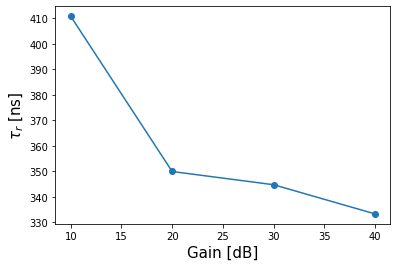

In [578]:
t_resp = [1e3/2.43448517e+00, 1e3/2.85783458e+00,  1e3/2.90082385e+00, 1e3/3.00039604e+00]
PDA_gain = [10, 20, 30, 40]

plt.plot(PDA_gain, t_resp, 'o-')
plt.xlabel("Gain [dB]", fontsize=15)
plt.ylabel(r"$\tau_{r}$ [ns]", fontsize=15)

In [ ]:
#Test fit the whole square convolution 

# Signal processing

## Short pulse for test reponse

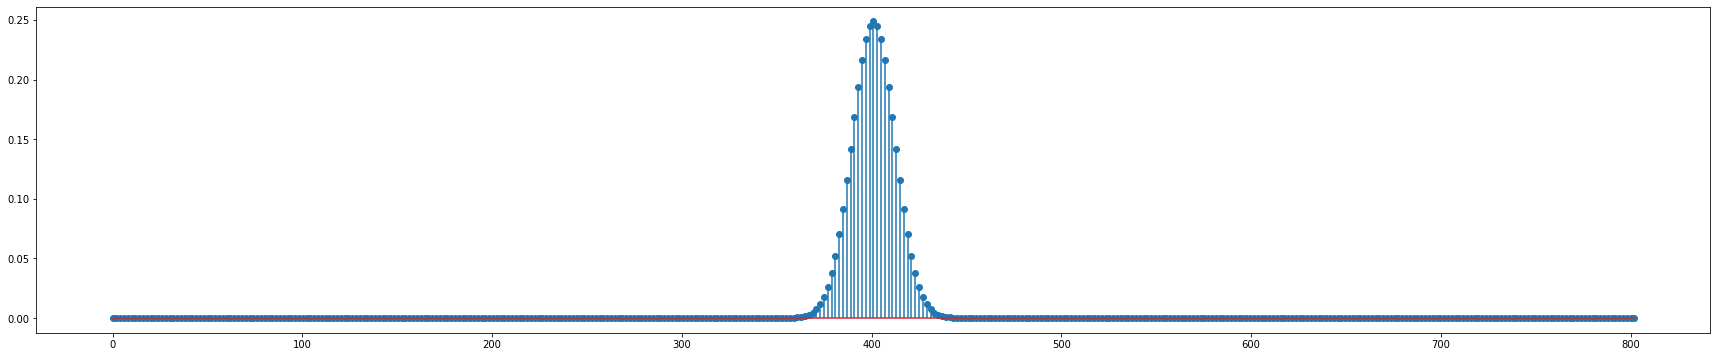

In [71]:
#gaussian 800ns, 400 points, centered in 400ns, stdev 200ns, gain 10
spns = 0.5
res = 1/spns
pulse_time = 802.0

nr_points = pulse_time/res

args = {'sampling':round(nr_points), 'bitdepth':16, 'time_dyn':pulse_time};
params = aqipt.general_params(args); #get params AQiPT object from dictionary
tbase = params.timebase(); #obtain time-base from params object

args_lst={'mean':pulse_time/2, 'std':pulse_time/50, 'gain':0.1e2,'name': 'gaussian_50ns', 'color': 'blue'}

plt.figure(figsize=(30,6));
gaussian_800ns, pt = aqipt.function(tbase, args_lst).STIRAP_gaussian(plotON=False)


Some functions that can be use as kernels

In [258]:
def aomTF(t, t0, w, omega):
    return np.exp(-((t-t0)**2)*((w**2)/(np.pi**2))*np.log(2))# * np.exp(-1j*omega*t)
def aomTF2(t, w, omega):
    return np.exp(-(t*t)*((w**2)/(np.pi**2))*np.log(2)) * np.repeat([0., 1., 0.], len(t))

def step_decay(t,amp, tau,t0):
    ''' Decay expoential and step function '''
    return amp*np.exp(-(t-t0)/tau) * 0.5*(np.sign(t-t0)+1.0)

def gaussian(tau, mu, sig):
    return np.exp(-np.power(tau - mu, 2.) / (2 * np.power(sig, 2.)))

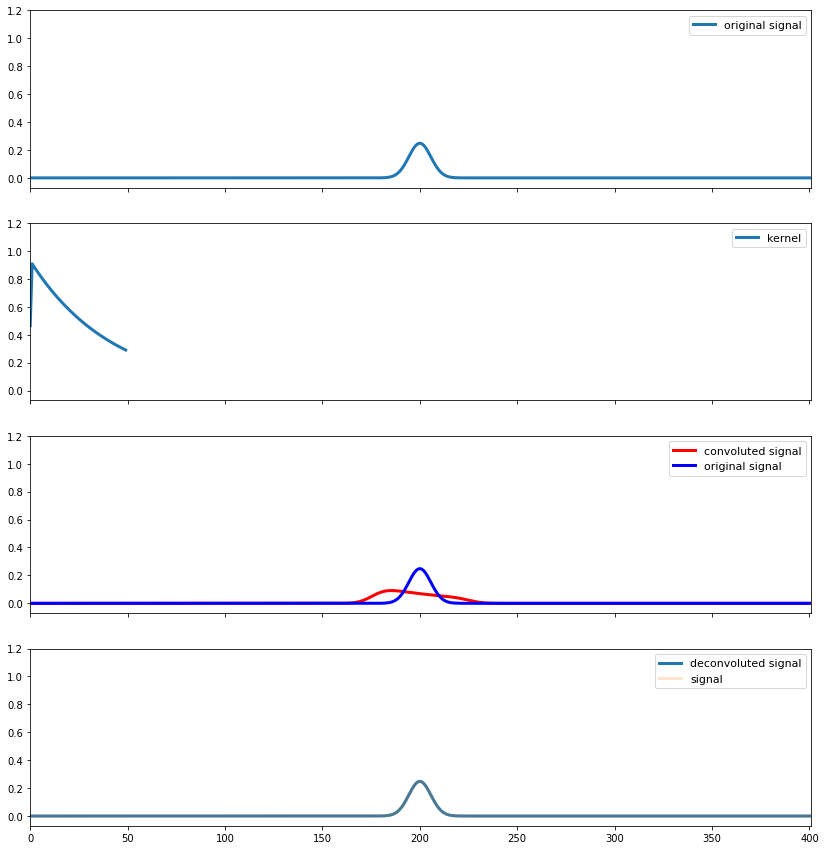

In [77]:

signal = gaussian_800ns;
kernel = np.flip(step_decay(np.linspace(0,250,50), 0.2e3, 215, 5));
kernel3 = step_decay(np.linspace(0,250,50), 0.2e3, 215, 0);

gauss1 = np.array(y)[(np.array(x) > -2.) & (np.array(x) < 4.5)];

#convolution 
filtered = np.convolve(signal, kernel3, mode='same') 

#deconvolution
deconv,  _ = scp.signal.deconvolve( filtered, kernel3 )

n = len(signal)-len(kernel3)+1
s = int((len(signal)-n)/2)

deconv_res = np.zeros(len(signal))
deconv_res[int(s):int(len(signal)-s-1)] = deconv
deconv = deconv_res
# deconv *= kernel3.sum()

#plot
fig , ax = plt.subplots(nrows=4, figsize=(14,15))

ax[0].plot(signal, label="original signal",     lw=3 ) 
ax[1].plot(kernel3, label="kernel", lw=3 )
ax[2].plot(filtered/np.sum(kernel3), label="convoluted signal" ,  lw=3, color='red')
ax[2].plot(signal, label="original signal",     lw=3, color='blue' ) 
ax[3].plot(deconv, label="deconvoluted signal", lw=3 ) 
ax[3].plot(signal, label="signal", lw=3, alpha=0.2) 

for i in range(len(ax)):
    ax[i].set_xlim([0, len(signal)])
    ax[i].set_ylim([-0.07, 1.2])
    ax[i].legend(loc=1, fontsize=11)
    if i != len(ax)-1 :
        ax[i].set_xticklabels([])


# Transfer matrix function / response function on data

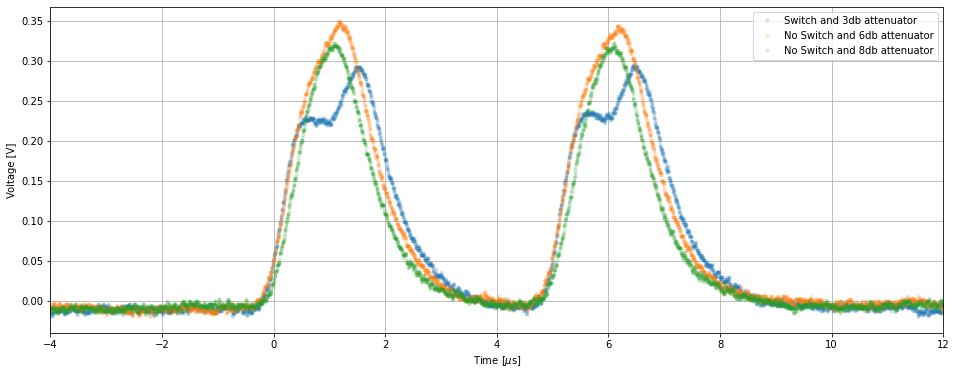

In [80]:
plt.figure(figsize=(16,6))

i=4
plt.plot([((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))], (traces[i])[1], '.', alpha=0.15, label='Switch and 3db attenuator');

i=5
plt.plot([((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))], (traces[i])[1], '.', alpha=0.15, label='No Switch and 6db attenuator');

i=6
plt.plot([((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))], (traces[i])[1], '.', alpha=0.15, label='No Switch and 8db attenuator');

plt.xlabel(r'Time [$\mu$s]');
plt.ylabel(r'Voltage [V]');
plt.xlim(-4,12);
plt.grid(True);
plt.legend();

In [576]:
#method transfer matrix (simple version) - forward transfer function
# CONVOLVED->DECONVOLVED
def fwd_TF(tbase_signal, signal,
               tbase_kernel, kernel,
               plotON=True):

    #convolution 
    filtered = np.convolve(signal, kernel, mode='same') 
    
    
    #deconvolution
    deconv,  _ = scp.signal.deconvolve( filtered, kernel )

    n = len(signal)-len(kernel)+1
    s = int((len(signal)-n)/2)

    deconv_res = np.zeros(len(signal))
    deconv_res[int(s):int(len(signal)-s-1)] = deconv
    deconv = deconv_res
    
    if plotON==True:
        
        #plot
        fig , ax = plt.subplots(nrows=3, figsize=(14,15))

        ax[0].plot(tbase_signal, signal, label="original signal", lw=3, color='dodgerblue' ) 
        ax[1].plot(tbase_kernel, kernel, label="kernel", lw=3,color='dodgerblue', alpha=0.4)
        ax[2].plot(tbase_signal, filtered/np.sum(kernel), label="convoluted signal" ,  lw=3, color='red')
#         ax[2].plot(tbase_signal, signal, label="original signal",     lw=3, color='dodgerblue', alpha=0.4) 
#         ax[3].plot(tbase_signal, deconv, label="deconvoluted signal", lw=3, color='dodgerblue', alpha=0.4) 
#         ax[3].plot(tbase_signal, signal, label="signal", lw=2, color='crimson', alpha=0.3) 

        for i in range(len(ax)):
            
#             if i == 1:
#                 ax[i].set_xlim([min(tbase_kernel), max(tbase_kernel)])
#                 ax[i].set_ylim([min(tbase_kernel), max(tbase_kernel)])
#                 if i != len(ax)-1 :
#                     ax[i].set_xticklabels([])
#             else:
#                 ax[i].set_xlim([min(signal), len(signal)])
#                 ax[i].set_ylim([min(signal), len(signal)])
#                 if i != len(ax)-1 :
#                     ax[i].set_xticklabels([])
                    
            ax[i].legend(loc=1, fontsize=11)
            
        return filtered, deconv, fig, ax
    else:
        return filtered, deconv

In [574]:
#method transfer matrix (simple version) - backward transfer function
# FILTER(Wiener)->DECONVOLVED->DOUBLEFILTER
def bck_TF(tbase_signal, signal,
           tbase_kernel, kernel,
           filter_range, wiener_size,
           plotON=True):
       
    #filtering signal
    b, a = scp.signal.butter(filter_range[0], filter_range[1]); #filtro Butterworth
#     filtered = scp.signal.filtfilt(b, a, signal); #senal filtrada por filtfilt
    filtered = scp.signal.wiener(signal, mysize=wiener_size); #senal filtrada por filtfilt

    #deconvolution
    deconv,  _ = scp.signal.deconvolve( signal, kernel)

    n = len(signal)-len(kernel)+1
    s = int((len(signal)-n)/2)

    deconv_res = np.zeros(len(signal))
    deconv_res[int(s):int(len(signal)-s-1)] = deconv
    deconv = deconv_res
    
    #filtering signal
#     deconv = scp.signal.wiener(signal, mysize=wiener_size); #senal filtrada por filtfilt
    deconv = scp.signal.filtfilt(b, a, signal); #senal filtrada por filtfilt

    if plotON==True:
        
        #plot
        fig , ax = plt.subplots(nrows=3, figsize=(14,15))

        ax[0].plot(tbase_signal, signal, label="measured signal", lw=3, color='dodgerblue' ) 
        ax[0].plot(tbase_signal, filtered, label="filtered measured signal", lw=1, color='black' ) 
        
        ax[1].scatter(tbase_kernel, kernel, label="kernel", lw=3,color='dodgerblue', alpha=0.4)
        
        ax[2].plot(tbase_signal, deconv, label="filtered deconvoluted signal", lw=2, color='dodgerblue', alpha=0.4) 
#         ax[2].plot(tbase_signal, filtered, label="filtered measured signal", lw=2, color='crimson', alpha=0.3) 
        
        
        for i in range(len(ax)):
            
#             if i == 1:
#                 ax[i].set_xlim([min(tbase_kernel), max(tbase_kernel)])
#                 ax[i].set_ylim([min(tbase_kernel), max(tbase_kernel)])
#                 if i != len(ax)-1 :
#                     ax[i].set_xticklabels([])
#             else:
#                 ax[i].set_xlim([min(signal), len(signal)])
#                 ax[i].set_ylim([min(signal), len(signal)])
#                 if i != len(ax)-1 :
#                     ax[i].set_xticklabels([])
                    
            ax[i].legend(loc=1, fontsize=11)
            
        return deconv,filtered, fig, ax
    else:
        return deconv,filtered

We use the measured waveform (ugly one) to recover the original two nice gaussians of 500mus. We use ```fwd_TF()```

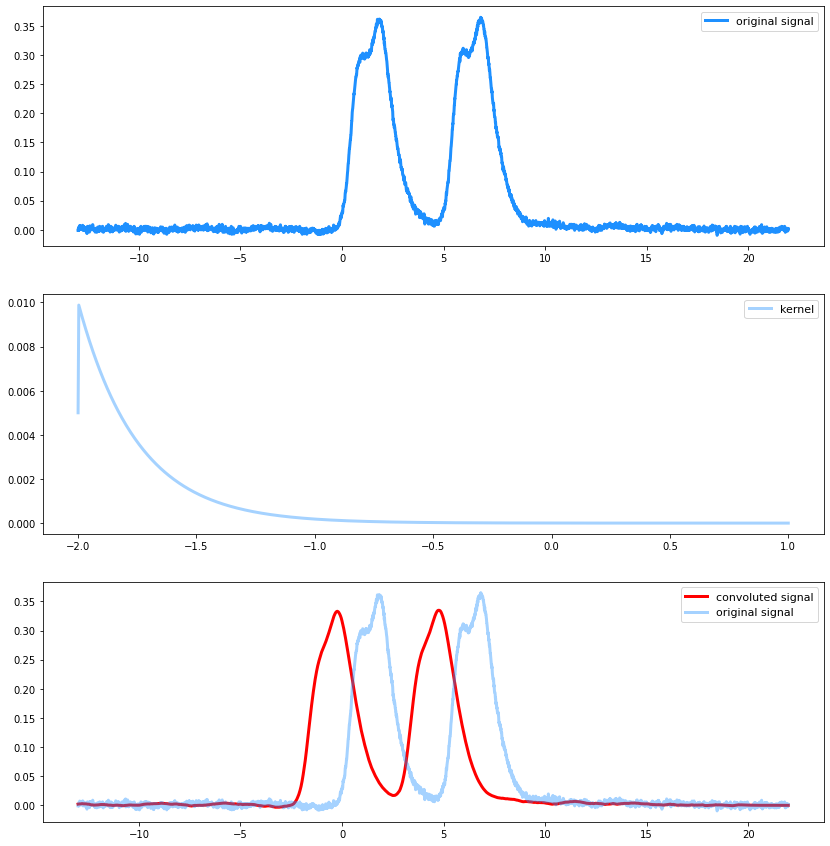

In [423]:
#signal
i=0; #waveform nr
tbase_signal = [((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]; #time domain
signal = (traces[i])[1]; #range values

#kernel
tbase_kernel = np.linspace(-2,1,1000);#time domain
kernel = step_decay(tbase_kernel, 0.01, 0.25, -2); #range values

convf, deconvf, fig, axs = fwd_TF(tbase, signal, tbase_kernel,kernel, plotON=True); #transfer matrix analysis


We use the measured waveform (ugly one) to recover the original two nice gaussians of 500mus. We use ```bck_TF()```

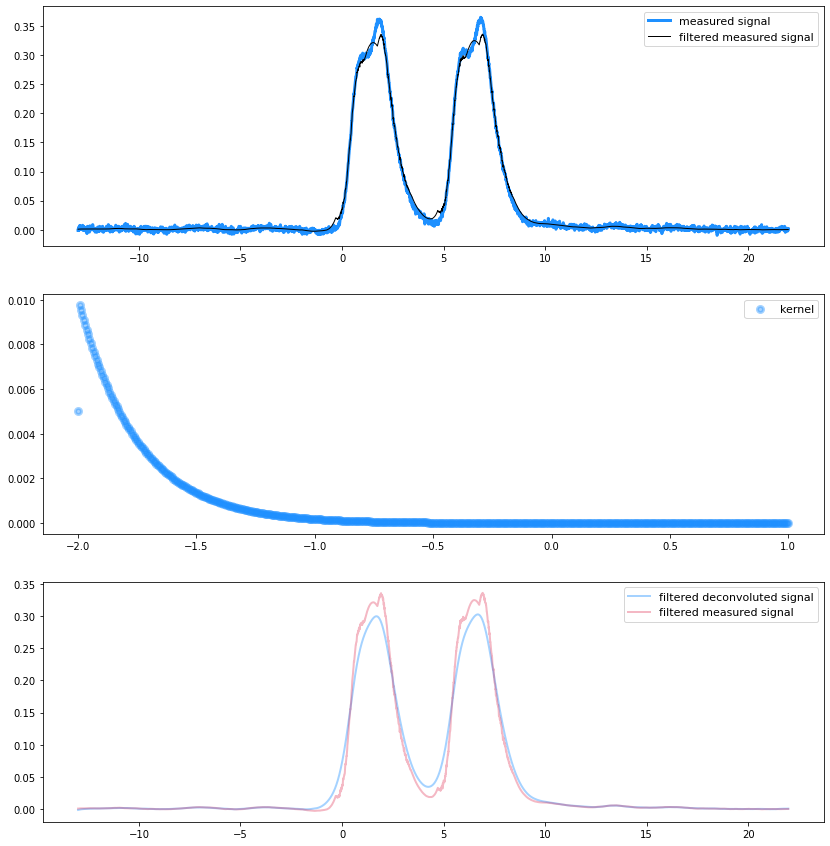

In [558]:
#signal
i=0; #waveform nr
tbase_signal = [((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]; #time domain
signal = (traces[i])[1]; #range values

#kernel
tbase_kernel = np.linspace(-2,1,500);#time domain
kernel = step_decay(tbase_kernel, 0.01, 0.25, -2); #range values

deconvf,filtered, fig, axs = bck_TF(tbase, signal, tbase_kernel,kernel,[1,0.0035], np.array(288), plotON=True); #transfer matrix analysis




Convoluting the original waveform after AWG (envelope+carrier), with the response function of characteristic time of 250ns, we get a two gaussians with litle visibilityu of small features.

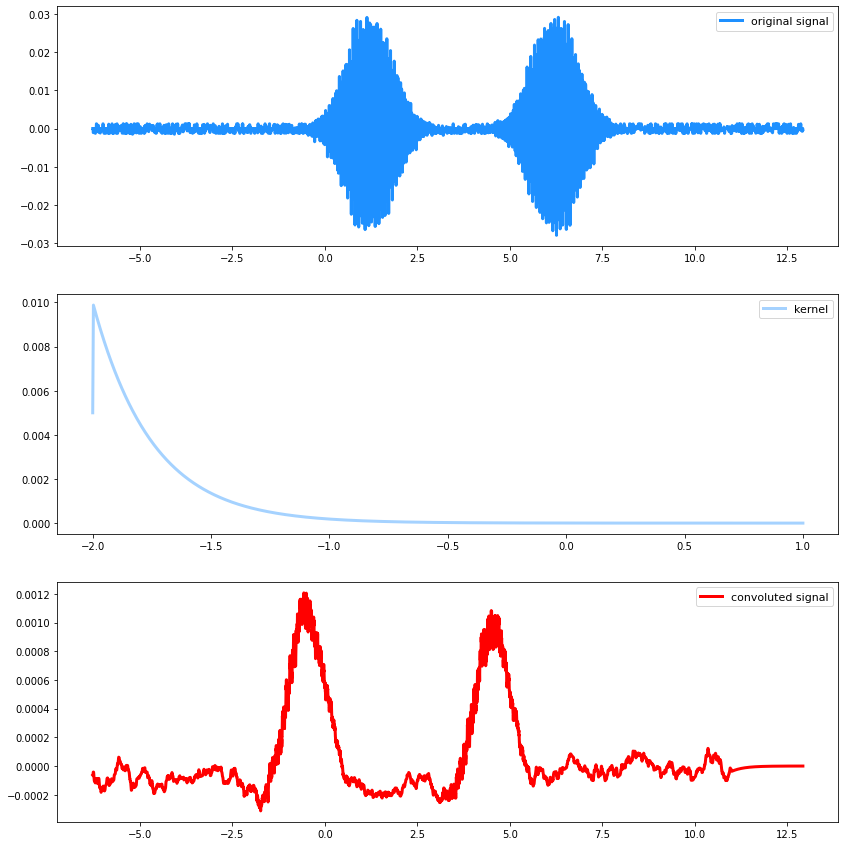

In [590]:
i=7
x=[((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]
y=(traces[i])[1]

#signal
i=7; #waveform nr
tbase_signal = x
signal = y

#kernel
tbase_kernel = np.linspace(-2,1,1000);#time domain
kernel = step_decay(tbase_kernel, 0.01, 0.25, -2); #range values

convf, deconvf, fig, axs = fwd_TF(tbase_signal, signal, 
                                  tbase_kernel, kernel, plotON=True); #fwd transfer matrix analysis


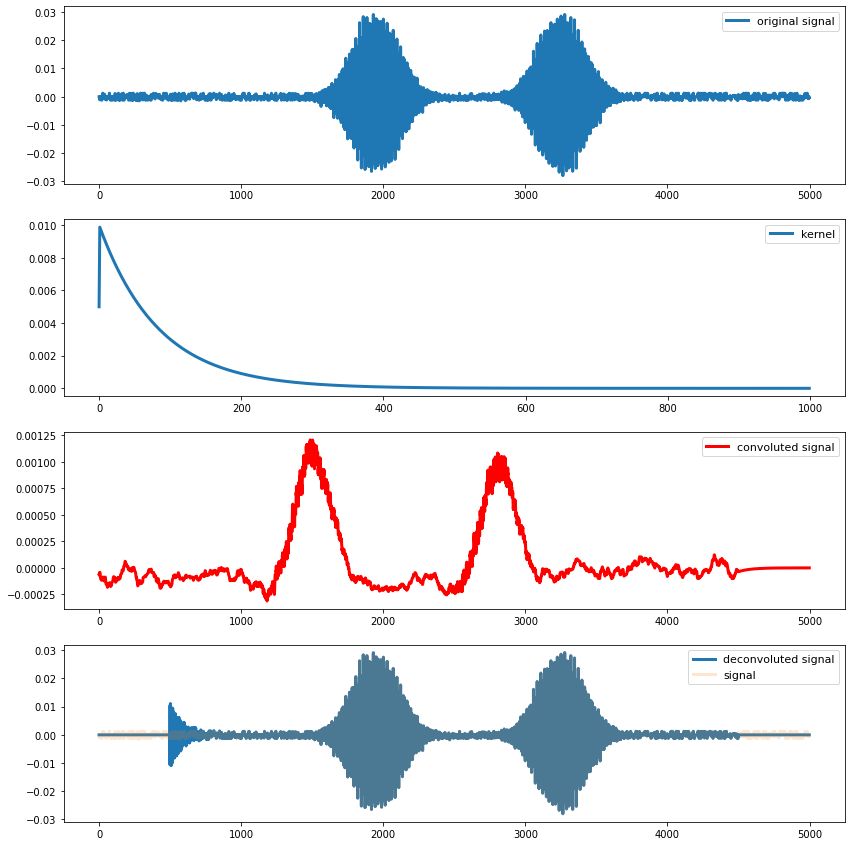

In [589]:

#convolution 
filtered = np.convolve(signal, kernel, mode='same') 

#deconvolution
deconv,  _ = scp.signal.deconvolve( filtered, kernel )

n = len(signal)-len(kernel)+1
s = int((len(signal)-n)/2)

deconv_res = np.zeros(len(signal))
deconv_res[int(s):int(len(signal)-s-1)] = deconv
deconv = deconv_res

#plot
fig , ax = plt.subplots(nrows=4, figsize=(14,15))

ax[0].plot(signal, label="original signal",     lw=3 ) 
ax[1].plot(kernel, label="kernel", lw=3 )
ax[2].plot(filtered/np.sum(kernel), label="convoluted signal" ,  lw=3, color='red')
# ax[2].plot(signal, label="original signal",     lw=3, color='blue' ) 
ax[3].plot(deconv, label="deconvoluted signal", lw=3 ) 
ax[3].plot(signal, label="signal", lw=3, alpha=0.2) 

for i in range(len(ax)):
#     ax[i].set_xlim([0, len(signal)])
#     ax[i].set_ylim([-0.07, 1.2])
    ax[i].legend(loc=1, fontsize=11)
#     if i != len(ax)-1 :
#         ax[i].set_xticklabels([])


## Optimization

We want to optimize the way we find the original waveform 

```Python

#signal
i=0; #waveform nr
tbase_signal = [((traces[i])[0])[k]/1e-6 for k in range(len(((traces[i])[0])))]; #time domain
signal = (traces[i])[1]; #range values

#kernel
tbase_kernel = np.linspace(-2,1,500);#time domain
kernel = step_decay(tbase_kernel, 0.01, 0.25, -2); #range values

deconvf,filtered, fig, axs = bck_TF(tbase, signal, tbase_kernel,kernel,[1,0.0035], np.array(288), plotON=True); #transfer matrix analysis



```

In [ ]:
def optimizer(deconvF, kernelF, traces, wf_nr, range_kernel, filter_range,  *args):
    
    for l in args['sampling_kernel']:
        for i in args['amplitude']:
            for j in args['tau']:
                for k in args['to']:
                
                    params = {'amplitude': i, 'tau': j, 'to': k, 'kernel_samp': l}; #params for deconvolution
    
                    #signal
                    tbase_signal = [((traces[wf_nr])[0])[k]/1e-6 for k in range(len(((traces[wf_nr])[0])))]; #time domain
                    signal = (traces[wf_nr])[1]; #range values

                    #kernel
                    tbase_kernel = np.linspace(range_kernel[0], range_kernel[1], params['kernel_samp']);#time domain
                    kernel = kernelF(tbase_kernel, params['amplitude'], params['tau'], params['to']); #range values

                    deconvf, fig, axs = deconvF(tbase_signal, signal, 
                                                tbase_kernel, kernel, plotON=False); #transfer matrix analysis
                    
                    cost = cost_F(signal, deconvf); #cost function

def cost_F(f, g):
    return (f-g)**2